# Tutorial 3: Enrichment analysis

We performed differential expression (DE) analysis between TSKs and surrounding immune cells, and obtained ranked list of DE genes. Then we employed gene set enrichment analysis (GSEA) on DE genes.

In [1]:
library(GSEABase)
library(DOSE)
library(fgsea)
library(Seurat)
library(ggplot2)
library(clusterProfiler)
library(stringr)

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: annotate

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges


DE analysis

In [2]:
sc_data_path="../data/T3_sc/"
meta=read.table(paste0(sc_data_path, "patient_metadata_new.txt"), sep="\t")
meta_tumor=meta[meta$tum.norm=="Tumor",]
count=read.table(paste0(sc_data_path, "merge10pts_counts.txt"), sep="\t", header=T)
count=count[3:dim(count)[1],]
count_tumor=count[,rownames(meta_tumor)]
sc_data=CreateSeuratObject(count_tumor, meta.data = meta_tumor)

Warning message:
"Feature names cannot have underscores ('_'), replacing with dashes ('-')"


In [3]:
sc_meta <- read.csv(paste0(sc_data_path, "adata_sc_keep_obs.csv"), row.names = 1)
sc_data <- sc_data[,rownames(sc_meta)]
sc_data <- AddMetaData(sc_data, metadata = sc_meta[,c("T_exhaustion_score","microenv")])
sc_data <- NormalizeData(sc_data)

In [4]:
DE_tumor <- FindMarkers(object = sc_data, ident.1 = "TSK_immune", ident.2 = "TSK", group.by = "microenv")
DE_tumor <- DE_tumor[order(DE_tumor$avg_log2FC, decreasing = TRUE), ]
gene_list <- DE_tumor$avg_log2FC
names(gene_list) <- rownames(DE_tumor)

GSEA

In [5]:
pathway <- read.gmt(paste0(sc_data_path, "h.all.v2023.1.Hs.symbols.gmt"))
pathway_list <- lapply(split(pathway$gene, pathway$term), as.character)
fgseaRes <- fgseaMultilevel(pathway_list, gene_list, maxSize=500)
fgseaRes <- fgseaRes[order(fgseaRes$padj, decreasing = FALSE), ]
fgseaRes_top <- fgseaRes[1:10,]

In [6]:
fgseaRes_top$pathway <- str_replace_all(fgseaRes_top$pathway, c("HALLMARK_"=""))
fgseaRes_top$pathway <- str_replace_all(fgseaRes_top$pathway, c("_"=" "))
fgseaRes_top$pathway <- factor(fgseaRes_top$pathway, levels = rev(fgseaRes_top$pathway))

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


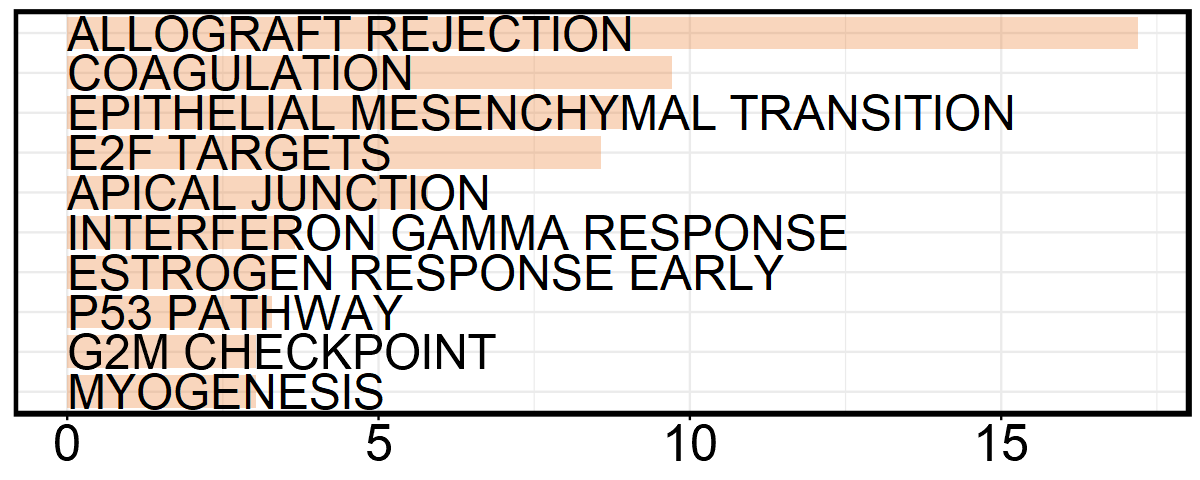

In [7]:
options(repr.plot.width = 10, repr.plot.height = 4)
ggplot(fgseaRes_top, aes(x = -log10(padj), y = pathway)) +
    geom_bar(fill = "#ec7722", width = .8, position = 'dodge', stat = "identity", alpha = 0.3) +
    geom_text(aes(label = pathway, x = 0), hjust = 0, size = 10) +
    theme_bw() +
    labs(x="",y="",fill="") + 
    theme(axis.text.y = element_blank(), 
          axis.ticks.y = element_blank(),
          axis.title.y = element_blank(),
          plot.title = element_text(hjust = 0, size = 20),
          plot.subtitle = element_text(hjust = 0, size = 20),
          axis.text.x = element_text(hjust = 0.5, size = 30, color = "black"),
          axis.title.x = element_blank(),
          axis.ticks.x = element_line(color = "black"),
          legend.position = c(0.8,0.9),
          legend.title = element_text(size = 15),
          legend.text  = element_text(size = 15),
          legend.key.size = unit(1, "lines"),
          panel.border = element_rect(color = "black", size = 2))